In [1]:
import numpy as np
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

### Создание исходного набора данных, разбиение на обучающую и тренировочную выборки:

In [2]:
X, Y = make_classification(n_samples=1000, n_features=3, n_informative=2, n_classes=3, n_clusters_per_class=1, n_redundant=1, random_state=13, class_sep=1.5)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle=True, random_state=13)

### Визуализируем созданную тренировочную выборку:

In [3]:
# Функция разбиения тренировочной выборки на классы 0 и 1
def make_split(x, y, target_class):
    x_target = []
    y_target = []
    for i in range(len(y)):
        if y[i] == target_class:
            x_target.append(x[i])
            y_target.append(y[i])
    
    return np.array(x_target), np.array(y_target)

In [4]:
x_0, y_0 = make_split(x_train, y_train, 0)
x_1, y_1 = make_split(x_train, y_train, 1)
x_2, y_2 = make_split(x_train, y_train, 2)

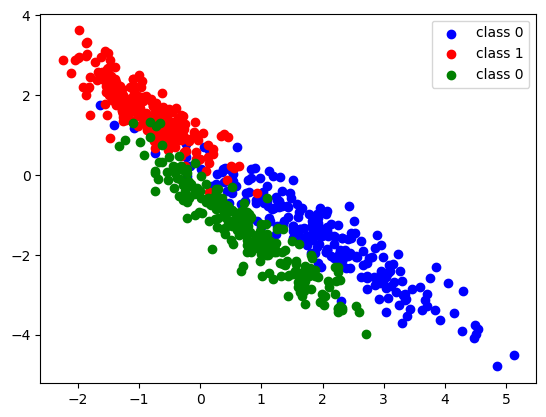

In [5]:
plt.scatter(x_0[:, 0], x_0[:, 1], color='blue', label='class 0')
plt.scatter(x_1[:, 0], x_1[:, 1], color='red', label='class 1')
plt.scatter(x_2[:, 0], x_2[:, 1], color='green', label='class 0')
plt.legend()
plt.show()

### Метод KNN работает по следующему принципу:
1. Получение обучающей выборки
2. Сохранение выборки в переменную
3. Получение рабочей (для которой необходимо выполнить предсказание) выборки
4. Каждую точку из рабочей выборки необходимо сравнить с каждой точки обучающей выборки по каждому из признаков.

Необходимо:

    I) Найти квадраты отклонений каждого из признаков
    
    II) Проссумировать эти квадраты для каждой точки рабочей выборки (сравнивая с каждой точкой обучающей выборки)
    
    III) Извлечь из суммы квадратный корень. В итоге будет найдена норма - расстояние между каждой точкой рабочей и обучающей выборки
    
    IV) Определить N ближайших тестовых точек к данной точке рабочей выборки (в разрезе каждой точки рабочей выборки)
    
    V) На основании средневесового голосования определить класс точки. В качестве веса выступает обратное расстояние от тренировочной точки до рабочей точки (которое было определно в пункте III)

### Класс KNN:

In [6]:
class KNN:
    
    # инициализация метода KNN
    # Запоминание тестовой выборки
    def __init__(self, x_train:np.array, y_train:np.array):
        self.x_train = x_train
        self.y_train = y_train
    
    
    # расчет нормы n - порядка
    @staticmethod
    def _norma(x_work, x_train, n=2):
        result = 0
        for i in range(x_work.shape[0]):
            result += (x_work[i] - x_train[i])**n
        return result**(1/n)

    
    # Возвращения индексов n наименьших объектов в массиве
    @staticmethod
    def _find_n_smaller_objects(massive, n):
        indexes_of_min_values = []
        for i in range(n):
            min_value = np.inf
            index_of_min_value = None
            
            for j in range(len(massive)):
                if j in indexes_of_min_values:
                    continue
                if massive[j] < min_value:
                    min_value = massive[j]
                    index_of_min_value = j
                    
            indexes_of_min_values.append(index_of_min_value) 
        return indexes_of_min_values
    
    # Функция голосования за класс на основе весов - обратных расстояний от ближайших наблюдений
    # обучающей выборки до рассматриваемого наблюдения "рабочей" выборки
    @staticmethod
    def _vote(classes:list, reverse_weights:list):
        best_class = None
        max_weight = 0
        
        unique_values = np.unique(classes).tolist()
        total_weights = np.zeros_like(unique_values)
        
        for i, target_class in enumerate(classes):
            current_index = unique_values.index(target_class)
            total_weights[current_index] += 1 / (reverse_weights[i] + 1e-9)
        
        total_weights = list(total_weights)
        
        max_value = max(total_weights)
        index_of_max_value = total_weights.index(max_value)
        
        return unique_values[index_of_max_value]
    
    
    
    # Выполнение предсказания для одного наблюдения
    def _prediction_for_one_point(self, x_work, n_nearest_points):
        distances = []
        for x in self.x_train:
            distances.append(KNN._norma(x_work, x, n=2))
            
        n_smaller_indexes = KNN._find_n_smaller_objects(distances, n_nearest_points)
        
        list_of_min_distances  = []
        list_of_target_classes = []
        for smaller_index in n_smaller_indexes:
            list_of_min_distances.append(distances[smaller_index])
            list_of_target_classes.append(self.y_train[smaller_index])
        
        predicted_class = KNN._vote(list_of_target_classes, list_of_min_distances)
        return predicted_class
    
    # Функция предсказания для наблюдений
    def predict(self, x_work:np.array, n_nearest_points):
        y_pred = []
        for x in x_work:
            y_pred.append(self._prediction_for_one_point(x, n_nearest_points))
        
        return np.array(y_pred)
    
    # Функция расчета доли правильных ответов
    @staticmethod
    def get_accuracy(y_true:np.array, y_pred:np.array):
        k = 0
        for i in range(y_true.shape[0]):
            if y_true[i] == y_pred[i]:
                k += 1
        return round(k / y_true.shape[0], 3)

In [7]:
# Создание экземляра класса, обучение метода KNN
knn = KNN(x_train, y_train)

In [8]:
# Проверка на обучающей выборке:
# 1. Предсказание на обучающей выборке:
y_pred_train = knn.predict(x_train, 5)
# 2. Проверка доли правильных ответов:
print(f'Доля правильных ответов на обучающей выборке равна {KNN.get_accuracy(y_pred_train, y_train)}')

Доля правильных ответов на обучающей выборке равна 1.0


In [9]:
# Проверка на тестовой выборке:
# 1. Предсказание на тестовой выборке:
y_pred_test = knn.predict(x_test, 5)
# 2. Проверка доли правильных ответов:
print(f'Доля правильных ответов на тестовой выборке равна {KNN.get_accuracy(y_pred_test, y_test)}')

Доля правильных ответов на тестовой выборке равна 0.893
